# Matrix Factorization via Singular Value Decomposition

SVD is an algorithm that decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where R is users's ratings matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values (essentially weights), and $V^{T}$ is the movie "features" matrix. $U$ and $V^{T}$ are orthogonal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, we take these matrices and keep only the top $k$ features, which we think of as the underlying tastes and preferences vectors.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Get Data

Get data from [MovieLens](https://grouplens.org/datasets/movielens/). Download MoiveLens 1M dataset and put it in `./dataset`

In [2]:
# Ratings
ratings_df = pd.read_csv('./dataset/ratings.dat', sep="::", header=None, 
                         names=['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype=int, 
                         engine='python')
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
np.unique(ratings_df['Rating'].values)

array([1, 2, 3, 4, 5])

In [4]:
ratings_df['UserID'].unique().shape

(6040,)

In [5]:
ratings_df.shape

(1000209, 4)

In [6]:
# Users
users_df = pd.read_csv('./dataset/users.dat', sep="::", header=None, 
                       names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [7]:
users_df.shape

(6040, 5)

In [8]:
# Movies
movies_df = pd.read_csv('./dataset/movies.dat', sep="::", header=None, 
                       names=['MovieID', 'Title', 'Genres'], engine='python')
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### create (i, j) index pair for testing set

In [9]:
# store the user id and movie id that have bee rated after certain timestamp
T = 980000000
test_uid = ratings_df.loc[ratings_df["Timestamp"]>T,"UserID"].tolist()
test_mid = ratings_df.loc[ratings_df["Timestamp"]>T,"MovieID"].tolist()

In [10]:
# size of testing set
len(test_uid)

82931

# Construct Rating Matrix

In [11]:
R_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
R_df.shape

(6040, 3706)

In [12]:
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
R_df.loc[5,6]

2.0

In [14]:
R = R_df.as_matrix()
rated_index = np.nonzero(R) # x, y pairs that are nonzero value
print(len(rated_index[0])," rating record")

1000209  rating record


So far, we have construct a complete user-ratings matrix.

# Create Train and Test Set

Use the index we save above and set their ratings to **zero** in the user-ratings dataframe. Our goal is to predict those zero and compare with the original ratings.

In [15]:
R_train_df = R_df # training matrix
test_y = []
for i,j in zip(test_uid, test_mid):
    test_y.append(R_df.loc[i, j]) # store the groundtruth rating
    R_train_df.loc[i, j] = 0 # set position (x, y) to zero in training matrix

R_train = R_train_df.as_matrix()

In [16]:
# De-mean the training data (normalize by each users mean)
user_ratings_mean = np.mean(R_train, axis=1)
print(user_ratings_mean.shape)
R_demeaned_train = R_train - user_ratings_mean.reshape(-1,1)

(6040,)


# Define Evaluation

In [17]:
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Singular Value Decomposition (Train)

In [18]:
from scipy.sparse.linalg import svds

In [19]:
latent = 50 # rank
U, Sigma, Vt = svds(R_demeaned_train, k=latent)

In [20]:
Sigma # singular value

array([  143.31863645,   144.24919641,   144.54984068,   144.91768804,
         148.32295688,   149.90214802,   151.05007402,   151.70926957,
         152.76484268,   154.12302823,   154.65227007,   156.44277847,
         157.8584406 ,   159.45273508,   159.835295  ,   160.21463011,
         163.74393508,   164.57004569,   166.39213572,   167.48245147,
         173.00545218,   175.84105139,   177.74493371,   178.94260613,
         183.47714506,   186.05691052,   188.53051707,   194.97007086,
         197.01797196,   204.51990219,   206.04255415,   209.91261817,
         215.30971432,   226.70628788,   231.64134446,   239.30453509,
         244.40084892,   250.39090959,   266.21582143,   279.93000728,
         305.62005216,   326.66108904,   334.62202079,   352.27343423,
         399.17874472,   420.48834796,   480.78029787,   558.2558092 ,
         642.30804208,  1453.2506477 ])

# Making Predictions from the Decomposed Matrices

In [21]:
all_user_predicted_ratings =  U @ np.diag(Sigma) @ Vt + user_ratings_mean.reshape(-1,1)

In [26]:
all_user_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns, index=R_df.index)
all_user_predicted_ratings_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,4.171579,0.192684,-0.222288,-0.028729,0.027315,-0.185608,-0.011566,0.137880,-0.069794,-0.224909,...,0.025437,0.011242,0.024085,-0.021128,-0.090847,0.515925,0.169357,0.027380,0.058209,0.186207
2,0.705920,0.152438,0.346916,0.040115,0.002605,1.294574,0.057542,0.055424,0.167967,1.602338,...,-0.020978,-0.016344,-0.006539,0.076363,-0.003280,-0.001925,-0.219375,-0.042795,-0.062914,-0.095498
3,1.903073,0.495590,0.096907,-0.057269,-0.021756,-0.111188,-0.099336,0.104797,0.020666,0.703395,...,0.013150,0.001527,0.006095,0.028463,-0.016146,0.032950,-0.042907,-0.000818,-0.026746,-0.158967
4,0.361471,-0.077703,0.044001,0.073716,0.082478,0.246715,-0.021966,0.018297,0.039337,-0.141990,...,-0.013207,-0.008951,-0.018036,-0.001364,-0.073373,0.048542,0.035959,-0.003907,0.021460,0.043224
5,1.458982,0.010544,-0.089584,0.226303,-0.021040,1.500511,-0.229138,0.018941,-0.056274,0.597634,...,0.056810,0.034098,0.006070,-0.001784,-0.024497,0.567242,0.441459,0.057976,0.166506,0.457215


In [27]:
RMSE(R, all_user_predicted_ratings)

0.54534685748114575

In [36]:
pred_y = []
for i,j in zip(test_uid, test_mid):
    pred_y.append(all_user_predicted_ratings_df.loc[i, j])
#
pred_y = np.array(pred_y)
pred_y = np.clip(np.round(pred_y), 1, 5)

In [37]:
RMSE(pred_y, test_y)

2.6072189720522152

In [38]:
pred_y

array([ 3.,  1.,  1., ...,  1.,  1.,  1.])

# Making Movie Recommendations

In [39]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.171579,0.192684,-0.222288,-0.028729,0.027315,-0.185608,-0.011566,0.137880,-0.069794,-0.224909,...,0.025437,0.011242,0.024085,-0.021128,-0.090847,0.515925,0.169357,0.027380,0.058209,0.186207
1,0.705920,0.152438,0.346916,0.040115,0.002605,1.294574,0.057542,0.055424,0.167967,1.602338,...,-0.020978,-0.016344,-0.006539,0.076363,-0.003280,-0.001925,-0.219375,-0.042795,-0.062914,-0.095498
2,1.903073,0.495590,0.096907,-0.057269,-0.021756,-0.111188,-0.099336,0.104797,0.020666,0.703395,...,0.013150,0.001527,0.006095,0.028463,-0.016146,0.032950,-0.042907,-0.000818,-0.026746,-0.158967
3,0.361471,-0.077703,0.044001,0.073716,0.082478,0.246715,-0.021966,0.018297,0.039337,-0.141990,...,-0.013207,-0.008951,-0.018036,-0.001364,-0.073373,0.048542,0.035959,-0.003907,0.021460,0.043224
4,1.458982,0.010544,-0.089584,0.226303,-0.021040,1.500511,-0.229138,0.018941,-0.056274,0.597634,...,0.056810,0.034098,0.006070,-0.001784,-0.024497,0.567242,0.441459,0.057976,0.166506,0.457215


In [40]:
pred_y[:10]

array([ 3.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.])

In [41]:
np.array(preds_df.iloc[836].sort_values(ascending=False).index)

array([ 858, 1221, 2028, ..., 1206, 1210,  919], dtype=int64)

In [42]:
np.array(ratings_df[ratings_df.UserID==(837)]["MovieID"])

array([1248, 2991, 1252,  589,    6, 1267, 1276, 1292,  905,  910, 1446,
        913, 3068, 1610, 1617,  942, 3083, 2289,  955, 3095, 3417, 3418,
       3435,  296, 3654, 2858,  457, 3683, 1304, 1177, 1179, 1188, 3101,
       2300, 2186, 1387,  858, 3307,  110, 3341, 3504, 3362, 3366, 2571,
        164, 2726, 1783,  318, 2599, 1961,   34, 1036, 3720, 3735, 2935,
       2791, 2000, 1201, 2944, 2947, 2948, 2949, 1213, 1221, 1222, 2028,
       1233,  707, 1244])

In [43]:
# Recommend top five (num_recommendations) movies
# Return: Top five movies that user has already rated and top five recommend movies
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    
    # UserID starts at 1
    sorted_user_predictions = np.array(preds_df.iloc[user_row_number].sort_values(ascending=False).index)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID==(userID)]
    # TODO
    user_full = np.array(ratings_df[ratings_df.UserID==(userID)]["MovieID"])
    
    print('User {0} has already rated {1} movies.'.format(userID, len(user_full )))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = [i for i in sorted_user_predictions if i not in user_full][:num_recommendations]
    return user_full, recommendations

In [44]:
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [45]:
already_rated[:10]

array([1248, 2991, 1252,  589,    6, 1267, 1276, 1292,  905,  910])

In [46]:
predictions

[527, 1953, 608, 1284, 1242, 2194, 922, 1230, 1954, 593]

# Questions

### Q1: Pleas plot the change of cost (RMSE or SSE) respect to latent.

In [49]:
latent_list = list(range(10,100,5))# rank
Loss = []
for latent in latent_list:
    U, Sigma, Vt = svds(R_demeaned_train, k=latent)
    all_user_predicted_ratings =  U @ np.diag(Sigma) @ Vt + user_ratings_mean.reshape(-1,1)
    all_user_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns=R_train_df.columns, index=R_train_df.index)
    pred_y = []
    for i, j in zip(test_uid, test_mid):
        pred_y.append(all_user_predicted_ratings_df.loc[i, j])
    pred_y = np.clip(np.round(pred_y), 1, 5)
#     pred_y = np.array(pred_y)
    Loss.append(RMSE(pred_y, test_y))

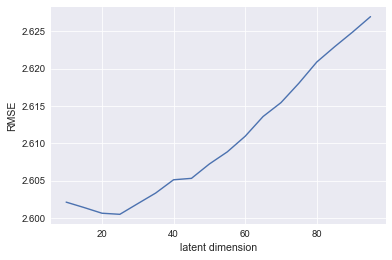

In [50]:
plt.plot(latent_list, Loss)
plt.xlabel("latent dimension")
plt.ylabel("RMSE")
plt.show()

### Q2: What is the best latent?

In [56]:
best_n = latent_list[np.argmin(Loss)]
print("The best latent dimension should be %d."%best_n)

The best latent dimension should be 25.


### Q3: Please randomly choose five users from your test sets and recommend 10 movies.

In [57]:
for user in [837, 12, 576, 2, 666]:
    already_rated, predictions = recommend_movies(preds_df, user, movies_df, ratings_df, 5)
    print(predictions)
    print()

User 837 has already rated 69 movies.
Recommending highest 5 predicted ratings movies not already rated.
[527, 1953, 608, 1284, 1242]

User 12 has already rated 23 movies.
Recommending highest 5 predicted ratings movies not already rated.
[318, 912, 608, 1225, 1207]

User 576 has already rated 57 movies.
Recommending highest 5 predicted ratings movies not already rated.
[1240, 2355, 912, 1374, 1291]

User 2 has already rated 129 movies.
Recommending highest 5 predicted ratings movies not already rated.
[1580, 733, 527, 1961, 1704]

User 666 has already rated 103 movies.
Recommending highest 5 predicted ratings movies not already rated.
[1704, 34, 17, 50, 589]



# Movie feature visualization

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=80)
vis_data = tsne.fit_transform(Vt.T)

In [60]:
vis_data.shape

(3706, 2)

In [61]:
movies_df["Genres"] = movies_df["Genres"].apply(lambda x:x.split("|")[0])
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation
1,2,Jumanji (1995),Adventure
2,3,Grumpier Old Men (1995),Comedy
3,4,Waiting to Exhale (1995),Comedy
4,5,Father of the Bride Part II (1995),Comedy


In [62]:
genres =[list(movies_df.loc[movies_df["MovieID"] == i,"Genres"]) for i in np.array(R_df.columns)]

In [63]:
genres = np.array(genres).squeeze()
len(genres)

3706

In [64]:
vis_data[:,1].shape

(3706,)

In [65]:
genres

array(['Animation', 'Adventure', 'Comedy', ..., 'Drama', 'Drama', 'Drama'],
      dtype='<U11')

In [66]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_c = le.fit_transform(genres)

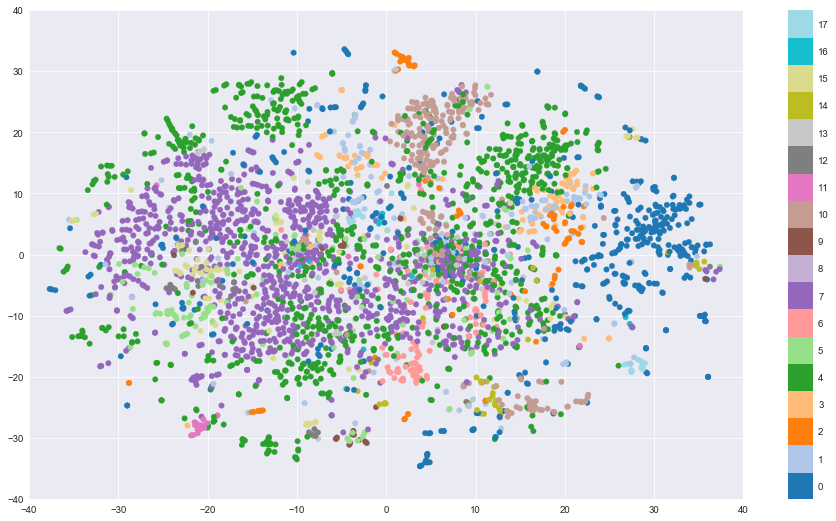

In [67]:
plt.figure(figsize=(16,9))
cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(vis_data[:,0], vis_data[:,1], c=y_c, cmap=cm)
plt.colorbar(ticks=range(18))
plt.clim(-0.5, 17.5)
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.show()

The above visualization shows the mapping of movie features from 95 dims to **2** dims using T-SNE. We can find out that the purple cluster and blue cluster, which are **Drama** and **Action** genres respectively, are somehow opposite. 

In [68]:
print("Look up table for class color and genres:")
pd.DataFrame({"class":list(range(18)),"genres":list(le.classes_)})

Look up table for class color and genres:


,class,genres
0,0,Action
1,1,Adventure
2,2,Animation
3,3,Children's
4,4,Comedy
5,5,Crime
6,6,Documentary
7,7,Drama
8,8,Fantasy
9,9,Film-Noir


# Reference
https://beckernick.github.io/matrix-factorization-recommender/